<a href="https://colab.research.google.com/github/kimwoonggon/publicservant_AI/blob/master/04_(%EA%B0%9C%EC%A0%95)%EC%BC%80%EB%9D%BC%EC%8A%A4%EB%A1%9C_Q%26A_%EA%B5%AC%ED%98%84%ED%95%98%EA%B8%B0_With_SQUAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><strong>케라스로 Q&A 구현하기 With SQUAD</strong></h1>
<h1><strong><u>Youtube 공무원AI</u></strong></h1>

![대체 텍스트](https://i.imgur.com/XSuDmcC.png)

이번 튜토리얼에서는 케라스와 BERT를 활용하여 <strong>SQUAD(Standford Question and Answering Dataset)</strong>을 실습해보고자 합니다.

SQUAD는 문장과 질문(Question)을 입력하면 그에 해당하는 답(ANSWER)를 알려주는 문제입니다.  
즉 AI가 영어 독해 문제를 풀어주는 것입니다.   
Tensorflow나 PyTorch로 SQUAD를 구현하는 코드들은 인터넷에 많지만 초보자 입장에서는 코드를 봐도 구현하기가 상당히 어렵습니다. 
막상 코드를 돌려봐도 어떤 원리로 돌아가는지 알기 어렵습니다.  
 
그래서 KERAS를 활용하여 쉽게 SQUAD를 구현해보고자 합니다.  
본 튜토리얼은 1)SQUAD 이해 2) BERT INPUT 만들기 3) SQUAD 구현 4) SQUAD 예측 총 4단계로 구성되어 있습니다.  
각 단계마다 이해하기 쉬운 설명을 곁들이도록 하겠습니다. 


<h2><strong> 1. SQUAD 개념 이해</strong></h2>  
SQUAD 문제는 아래와 같습니다.
Question을 하면 AI가 Context를 읽고 Answer를 출력값으로 알려주게 됩니다.  
처음에 나온 ANSWER는  AI가 예측한 정답입니다. 그리고 원래 정답은 Von Miller인데 왜 von miller ##r로 예측이 되었냐면, 실제로 예측한 것은 bert에 들어간 sentencepiece 토큰이 예측 된 것이기 때문입니다.  
  

![Imgur](https://i.imgur.com/sjf7vyj.png)  

사실 SQUAD는 ANSWER를 다 예측하는 것이 아니라, ANSWER 중에서도 시작단어와 끝 단어만을 예측합니다. 시작과 끝을 알면 자연스럽게 가운데 위치한 글자들도 예측이 되는 것이겠지요. 그리고 SQUAD 문제를 풀기 위해서 BERT 알고리즘을 사용합니다.  
  

위 그림에서 SQUAD는 ANSWER를 다 예측하는 것이 아니라, ANSWER 중에서도 시작단어와 끝 단어만을 예측합니다. 시작과 끝을 알면 자연스럽게 가운데 위치한 글자들도 예측이 되는 것이겠지요. 그리고 SQUAD 문제를 풀기 위해서 BERT 알고리즘을 사용합니다.  
  
  ![imgur](https://i.imgur.com/xhbWa13.png)  
  위 그림에서 버트 모형에 들어가는 인풋은 Question(질문)과 Paragraph(지문)입니다.  
  QUESTION과 PARAGRAPH가 버트의 인풋으로 들어가면 아웃풋 값으로 처음 단어와 큰 단어를 알려주게 됩니다.  

  Train Data의 생김새입니다. 총 87599개의 문장이 있습니다. Question과 Context를 인풋으로 받아서, 아웃풋으로 Text(정답)을 맞추게 됩니다.
  ![Imgur](https://i.imgur.com/rzTXJ1W.png)

  Test Data의 생김새입니다. 총 10,570개의 문장으로 이루어져 있으며, question과 context를 인풋으로 넣으면, 파인튜닝된 버트 모형이 text를 아웃풋 값으로 출력하게 됩니다.
  ![Imgur](https://i.imgur.com/s9zqAvv.png)


<h2><strong>2. BERT 사전학습 모형 가져오기</strong></h2>

https://github.com/google-research/bert 에 접속하셔서 BERT-Base, Multilingual Cased: 104 languages, 12-layer, 768-hidden, 12-heads, 110M parameters 파일을 다운 받으시길 바랍니다.

![대체 텍스트](https://i.imgur.com/RlutYyW.png)

<p>사전 학습 모형을 다운 받으셨다면, Colab에서 활용하기 위해 구글 GDRIVE에 업로드 하시길 바랍니다.</p>

![대체 텍스트](https://i.imgur.com/uM97zAQ.png)



<p> 누구나 쉽게 실습할 수 있도록 구글 Colaboratory를 활용하였습니다<br> <u>런타임->런타임 유형 변경에서 GPU를 꼭 선택하시기 바랍니다.</u><br>
그리고 데이터는 구글 G드라이브에 넣어 두었습니다. 사정에 맞게 폴더 경로를 변경하시기 바랍니다.</p>


In [0]:
# wget을 활용해서 bert 모델 다운로드 가능
!wget https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip

--2020-02-03 15:10:13--  https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 2a00:1450:4013:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662903077 (632M) [application/zip]
Saving to: ‘multi_cased_L-12_H-768_A-12.zip’

multi_cased_L-12_H- 100%[===================>] 632.19M  58.5MB/s    in 9.8s    

2020-02-03 15:10:29 (64.6 MB/s) - ‘multi_cased_L-12_H-768_A-12.zip’ saved [662903077/662903077]



In [0]:
import os
if "bert" not in os.listdir():
  os.makedirs("bert")
else:
  pass

import zipfile
import shutil
         
bert_zip = zipfile.ZipFile('multi_cased_L-12_H-768_A-12.zip')
bert_zip.extractall('bert')
 
bert_zip.close()

In [0]:
def copytree(src, dst, symlinks=False, ignore=None):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)

copytree("bert/multi_cased_L-12_H-768_A-12", "bert")

In [0]:
!wget https://raw.githubusercontent.com/nate-parrott/squad/master/data/train-v1.1.json
!wget https://raw.githubusercontent.com/nate-parrott/squad/master/data/dev-v1.1.json

--2020-02-03 15:11:00--  https://raw.githubusercontent.com/nate-parrott/squad/master/data/train-v1.1.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30288272 (29M) [text/plain]
Saving to: ‘train-v1.1.json’

train-v1.1.json     100%[===================>]  28.88M   106MB/s    in 0.3s    

2020-02-03 15:11:02 (106 MB/s) - ‘train-v1.1.json’ saved [30288272/30288272]

--2020-02-03 15:11:05--  https://raw.githubusercontent.com/nate-parrott/squad/master/data/dev-v1.1.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4854279 (4.6M) [text/pl

In [0]:
os.listdir()

['.config',
 'multi_cased_L-12_H-768_A-12.zip',
 'train-v1.1.json',
 'bert',
 'dev-v1.1.json',
 'sample_data']


##**구글 드라이브와 Colab을 연동합니다**

In [0]:
import os
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


<h2><strong>본격적으로 케라스와 버트를 활용하여 SQUAD 예측 모델을 만들어 보겠습니다.</strong></h2>

텐서플로우, 판다스, 넘파이, 케라스 등 필요한 모듈들을 임포트합니다

In [0]:
import tensorflow as tf

import pandas as pd
import numpy as np  
import re
import pickle

import keras as keras
from keras.models import load_model
from keras import backend as K
from keras import Input, Model
from keras import optimizers

from keras import backend as K
from keras.layers import Layer

import codecs
from tqdm import tqdm
import shutil
import json

Using TensorFlow backend.


In [0]:
import warnings
import tensorflow as tf
warnings.filterwarnings(action='ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.logging.set_verbosity(tf.logging.ERROR)

케라스에서 Bert 활용을 쉽게 만들어주는 모듈 keras-bert를 설치합니다<br>그리고 Adam optimizer의 수정판인 keras-radam 모듈을 임포트합니다.

In [0]:
!pip install keras-bert
!pip install keras-radam

  Created wheel for keras-bert: filename=keras_bert-0.81.0-cp36-none-any.whl size=37913 sha256=2b5b7409bfd51be2056b29d67b168db5d1283551bf7ccc83599c4e19f76f56ab
  Stored in directory: /root/.cache/pip/wheels/bd/27/da/ffc2d573aa48b87440ec4f98bc7c992e3a2d899edb2d22ef9e
  Created wheel for keras-transformer: filename=keras_transformer-0.32.0-cp36-none-any.whl size=13266 sha256=8809c477c88b494a1fb303bbd82aefdfd48004fac36dac644e2d6b4e30d45f67
  Stored in directory: /root/.cache/pip/wheels/62/f0/ce/82fa5d024d5ef8e263f26a50dcee23820efe245680ce9c922a
  Created wheel for keras-pos-embd: filename=keras_pos_embd-0.11.0-cp36-none-any.whl size=7553 sha256=b70650b15dc7374936aa9412784ac2f9c657d03d9bf04686d51cadcbc7133ccb
  Stored in directory: /root/.cache/pip/wheels/5b/a1/a0/ce6b1d49ba1a9a76f592e70cf297b05c96bc9f418146761032
  Created wheel for keras-multi-head: filename=keras_multi_head-0.22.0-cp36-none-any.whl size=15371 sha256=416356703fb468fa9227f5b365f52c1f771ceb4405bdb902004d7ac016fd8f1b
  Stor

keras-bert 라이브러리에서 버트 모형 활용에 필요한 모듈들을 임포트합니다

In [0]:
from keras_bert import load_trained_model_from_checkpoint, load_vocabulary
from keras_bert import Tokenizer
from keras_bert import AdamWarmup, calc_train_steps

from keras_radam import RAdam

SQUAD JSON파일을 PANDAS DATAFRAME으로 만들어주는 함수를 정의합니다.  
출처 : https://www.kaggle.com/sanjay11100/squad-stanford-q-a-json-to-pandas-dataframe

In [0]:
def squad_json_to_dataframe_train(input_file_path, record_path = ['data','paragraphs','qas','answers'],
                           verbose = 1):
    """
    input_file_path: path to the squad json file.
    record_path: path to deepest level in json file default value is
    ['data','paragraphs','qas','answers']
    verbose: 0 to suppress it default is 1
    """
    if verbose:
        print("Reading the json file")    
    file = json.loads(open(input_file_path).read())
    if verbose:
        print("processing...")
    # parsing different level's in the json file
    js = pd.io.json.json_normalize(file , record_path )
    m = pd.io.json.json_normalize(file, record_path[:-1] )
    r = pd.io.json.json_normalize(file,record_path[:-2])
    
    #combining it into single dataframe
    idx = np.repeat(r['context'].values, r.qas.str.len())
    ndx  = np.repeat(m['id'].values,m['answers'].str.len())
    m['context'] = idx
    js['q_idx'] = ndx
    main = pd.concat([ m[['id','question','context']].set_index('id'),js.set_index('q_idx')],1,sort=False).reset_index()
    main['c_id'] = main['context'].factorize()[0]
    if verbose:
        print("shape of the dataframe is {}".format(main.shape))
        print("Done")
    return main

SQUAD 데이터를 PANDAS DATAFRAME 형식으로 로드합니다.

In [0]:
train = squad_json_to_dataframe_train("train-v1.1.json")

Reading the json file
processing...
shape of the dataframe is (87599, 6)
Done


SQUAD 예측을 위한 훈련 데이터가 잘 로드되었습니다.  
**question 칼럼이 질문, context 칼럼이 문장으로 인풋으로 들어갑니다.  
아웃풋 값(정답)은 text 칼럼에서 시작 단어와 끝 단어 두 개 입니다. 예를 들어서, text 값이 Saint Bernadette Soubirous라면, 정답은 시작 단어인 Saint와 끝 단어인 Soubrious입니다.**  
  
그리고 SQUAD 문제의 특징은, 정답에 해당하는 아웃풋 값(text)이 context 안에 있다는 것입니다. 참고로 answer_start는 무시하셔도 됩니다. 왜냐하면 answer_start는 context 내에서 단어를 쪼갠 다음 쪼갠 것을 하나 하나 세어서 몇번째에 정답이 위치하는지를 알려주는 것입니다. 예를 들자면, context를 abcdefg라고 가정했을시 e가 정답(text)이라면, answer_start는 5가 됩니다. 
본 SQAUD 문제에서는 단어를 쪼갠 것을 하나 하나의 위치를 예측하는 것이 아니라, 단어의 시작 위치와 끝 위치를 예측하는 것이기 때문에 answer_start를 무시하셔도 됩니다.

In [0]:
train

,index,question,context,answer_start,text,c_id
0,5733be284776f41900661182,To whom did the Virgin Mary allegedly appear i...,"Architecturally, the school has a Catholic cha...",515,Saint Bernadette Soubirous,0
1,5733be284776f4190066117f,What is in front of the Notre Dame Main Building?,"Architecturally, the school has a Catholic cha...",188,a copper statue of Christ,0
2,5733be284776f41900661180,The Basilica of the Sacred heart at Notre Dame...,"Architecturally, the school has a Catholic cha...",279,the Main Building,0
3,5733be284776f41900661181,What is the Grotto at Notre Dame?,"Architecturally, the school has a Catholic cha...",381,a Marian place of prayer and reflection,0
4,5733be284776f4190066117e,What sits on top of the Main Building at Notre...,"Architecturally, the school has a Catholic cha...",92,a golden statue of the Virgin Mary,0
...,...,...,...,...,...,...
87594,5735d259012e2f140011a09d,In what US state did Kathmandu first establish...,"Kathmandu Metropolitan City (KMC), in order to...",229,Oregon,18890
87595,5735d259012e2f140011a09e,What was Yangon previously known as?,"Kathmandu Metropolitan City (KMC), in order to...",414,Rangoon,18890
87596,5735d259012e2f140011a09f,With what Belorussian city does Kathmandu have...,"Kathmandu Metropolitan City (KMC), in order to...",476,Minsk,18890
87597,5735d259012e2f140011a0a0,In what year did Kathmandu create its initial ...,"Kathmandu Metropolitan City (KMC), in order to...",199,1975,18890



- bert 훈련을 위한 사전 설정을 합니다. SEQ_LEN은 문장의 최대 길이입니다. SEQ_LEN 보다 문장의 길이가 작다면 남은 부분은 0이 채워지고, 만약에 SEQ_LEN보다 문장 길이가 길다면 SEQ_LEN을 초과하는 부분이 잘리게 됩니다.  
본 문제에서는 메모리 문제 등으로 384로 정했습니다.
- BATCH_SIZE는 메모리 초과 같은 문제를 방지하기 위해 작은 수인 10으로 정했습니다. 그리고 총 훈련 에포크 수는 2로 정했습니다. 학습율(LR;Learning rate)은 3e-5로 작게 정했습니다.
- pretrained_path는 bert 사전학습 모형이 있는 폴더를 의미합니다.
- 그리고 우리가 분석할 문장이 들어있는 칼럼의 제목인 document와 긍정인지 부정인지 알려주는 칼럼을 label로 정해줍니다


In [0]:
SEQ_LEN = 384
BATCH_SIZE = 10
EPOCHS=2
LR=3e-5

pretrained_path ="bert"
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

DATA_COLUMN = "context"
QUESTION_COLUMN = "question"
TEXT = "text"

vocab.txt에 있는 단어에 인덱스를 추가해주는 token_dict라는 딕셔너리를 생성합니다.  
우리가 분석할 문장이 토큰화가 되고, 그 다음에는 인덱스(숫자)로 변경되어서 버트 신경망에 인풋으로 들어게 됩니다.

In [0]:
token_dict = {}
with codecs.open(vocab_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        if "_" in token:
          token = token.replace("_","")
          token = "##" + token
        token_dict[token] = len(token_dict)

- BERT의 토큰화는 단어를 분리하는 토큰화 방식입니다. wordpiece(단어조각?) 방식이라고 하는데, 이는 한국어를 형태소로 꼭 변환해야 할 문제를 해결해주며, 의미가 있는 단어는 밀접하게 연관이 되게 하는 장점까지 갖추고 있습니다.
- 단어의 첫 시작은 ##가 붙지 않지만, 단어에 포함되면서 단어의 시작이 아닌 부분에는 ##가 붙는 것이 특징입니다.

In [0]:
tokenizer = Tokenizer(token_dict)

토큰화가 잘 되었는지 확인해 봅니다.
버트 모형은 문장 앞에 꼭 [CLS]라는 문자가 위치하고, [SEP]라는 문자가 끝에 위치합니다.  
[CLS]는 문장의 시작, [SEP]는 문장의 끝을 의미합니다.

In [0]:
print(tokenizer.tokenize("keras is reall fun."), tokenizer.tokenize("we can manipulate AI."))

['[CLS]', 'keras', 'is', 'real', '##l', 'fun', '.', '[SEP]'] ['[CLS]', 'we', 'can', 'mani', '##pul', '##ate', 'ai', '.', '[SEP]']


In [0]:
token_dict

{'[PAD]': 0,
 '[unused1]': 1,
 '[unused2]': 2,
 '[unused3]': 3,
 '[unused4]': 4,
 '[unused5]': 5,
 '[unused6]': 6,
 '[unused7]': 7,
 '[unused8]': 8,
 '[unused9]': 9,
 '[unused10]': 10,
 '[unused11]': 11,
 '[unused12]': 12,
 '[unused13]': 13,
 '[unused14]': 14,
 '[unused15]': 15,
 '[unused16]': 16,
 '[unused17]': 17,
 '[unused18]': 18,
 '[unused19]': 19,
 '[unused20]': 20,
 '[unused21]': 21,
 '[unused22]': 22,
 '[unused23]': 23,
 '[unused24]': 24,
 '[unused25]': 25,
 '[unused26]': 26,
 '[unused27]': 27,
 '[unused28]': 28,
 '[unused29]': 29,
 '[unused30]': 30,
 '[unused31]': 31,
 '[unused32]': 32,
 '[unused33]': 33,
 '[unused34]': 34,
 '[unused35]': 35,
 '[unused36]': 36,
 '[unused37]': 37,
 '[unused38]': 38,
 '[unused39]': 39,
 '[unused40]': 40,
 '[unused41]': 41,
 '[unused42]': 42,
 '[unused43]': 43,
 '[unused44]': 44,
 '[unused45]': 45,
 '[unused46]': 46,
 '[unused47]': 47,
 '[unused48]': 48,
 '[unused49]': 49,
 '[unused50]': 50,
 '[unused51]': 51,
 '[unused52]': 52,
 '[unused53]': 53

token dict의 key 값과 value 값을 바꾼 reverse_token_dict를 정의합니다.

In [0]:
reverse_token_dict = {v : k for k, v in token_dict.items()}

In [0]:
reverse_token_dict

{0: '[PAD]',
 1: '[unused1]',
 2: '[unused2]',
 3: '[unused3]',
 4: '[unused4]',
 5: '[unused5]',
 6: '[unused6]',
 7: '[unused7]',
 8: '[unused8]',
 9: '[unused9]',
 10: '[unused10]',
 11: '[unused11]',
 12: '[unused12]',
 13: '[unused13]',
 14: '[unused14]',
 15: '[unused15]',
 16: '[unused16]',
 17: '[unused17]',
 18: '[unused18]',
 19: '[unused19]',
 20: '[unused20]',
 21: '[unused21]',
 22: '[unused22]',
 23: '[unused23]',
 24: '[unused24]',
 25: '[unused25]',
 26: '[unused26]',
 27: '[unused27]',
 28: '[unused28]',
 29: '[unused29]',
 30: '[unused30]',
 31: '[unused31]',
 32: '[unused32]',
 33: '[unused33]',
 34: '[unused34]',
 35: '[unused35]',
 36: '[unused36]',
 37: '[unused37]',
 38: '[unused38]',
 39: '[unused39]',
 40: '[unused40]',
 41: '[unused41]',
 42: '[unused42]',
 43: '[unused43]',
 44: '[unused44]',
 45: '[unused45]',
 46: '[unused46]',
 47: '[unused47]',
 48: '[unused48]',
 49: '[unused49]',
 50: '[unused50]',
 51: '[unused51]',
 52: '[unused52]',
 53: '[unused53]'

**버트 모형에 들어갈 인풋은 토큰, 세그먼트, 포지션으로 구성됩니다.**  
버트에 인풋으로 들어가는 토큰은 문장을 토크나이징 한 후, 인덱스 번호를 매긴 것입니다.  
세그먼트는 예를 들어 문장이 두 개가 있다면, 앞의 문장과 뒤의 문장을 구분하는 것입니다.  
포지션 임베딩은 단순히 단어의 위치를 말합니다.

토큰, 세그먼트, 포지션을 인풋으로 버트 모형에 넣으면 기하학적인 문장 공간으로 임베딩이 됩니다.  
그림을 보면 my dog is cute, he likes play ##ing 두 문장이 있는데요  
SQUAD 문제에서는 첫번째 문장이 질문, 두번째 문장이 context가 되고, 이 두 문장이 합쳐져서 하나의 문장으로 들어가게 됩니다.

![대체 텍스트](https://i.imgur.com/l9BTao3.png)

- 사전학습된 버트 모델의 인풋은 문장 토큰화가 숫자로 바뀐 것과, 앞문장인지 뒷문장인지 알려주는 문장 순서 벡터가 들어갑니다. 우리는 문장 하나를 가지고만 훈련할 것이므로 순서 벡터는 모두 0으로 통일합니다.

- 그리고 파인튜닝 시에는 문장 안에 일부 단어를 가리는 마스킹은 사용하지 않습니다.

우리가 로드하였던 SQUAD 데이터를 **버트 모형의 입력에 맞게 변형해주는 함수**를 정의하도록 하겠습니다.

함수 내부에 tokenizer.encode 함수가 버트 모형을 토큰화해주고 토큰화 된 단어를 인덱스에 맞게 숫자로 바꿔주게 됩니다.  
**[CLS] 질문 [SEP] 문장 [SEP]** 이런 방식으로 질문과 문장이 인풋으로 들어가게 됩니다. SEQ_LEN이 384로 지정되어 있어서 길이가 384가 넘는 인풋은 문장 부분이 잘려서 들어가게 됩니다.  
SQUAD 문제에서 문장(context) 내에 text(정답)이 포함된다고 미리 말씀 드렸는데요, 길이가 384가 넘는 인풋인 경우에 context 내에 정답을 포함하고 있는 context가 잘려서 정답을 포함하지 않는 경우가 생깁니다. 이번 실습에서는 이러한 경우의 인덱스를 del_list로 지정해서, 빼도록 하겠습니다. (숙제로 남겨 두겠습니다.) 

In [0]:
question = train['question'][0]
context = train['context'][0]
text = train['text'][0]

In [0]:
# 질문
question

'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?'

In [0]:
# 문장
context

'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.'

In [0]:
# 정답
text

'Saint Bernadette Soubirous'

In [0]:
print(tokenizer.tokenize(question, context))

['[CLS]', 'to', 'whom', 'did', 'the', 'vir', '##gin', 'mar', '##y', 'allegedly', 'appear', 'in', '1858', 'in', 'lo', '##urde', '##s', 'franc', '##e', '?', '[SEP]', 'architectural', '##ly', ',', 'the', 'school', 'has', 'a', 'cat', '##hol', '##ic', 'character', '.', 'ato', '##p', 'the', 'main', 'building', "'", 's', 'gold', 'dome', 'is', 'a', 'golden', 'statue', 'of', 'the', 'vir', '##gin', 'mar', '##y', '.', 'immediately', 'in', 'front', 'of', 'the', 'main', 'building', 'and', 'facing', 'it', ',', 'is', 'a', 'copper', 'statue', 'of', 'ch', '##rist', 'with', 'arms', 'up', '##rais', '##ed', 'with', 'the', 'legend', '"', 'ven', '##ite', 'ad', 'me', 'om', '##nes', '"', '.', 'next', 'to', 'the', 'main', 'building', 'is', 'the', 'basilica', 'of', 'the', 'sacred', 'heart', '.', 'immediately', 'behind', 'the', 'basilica', 'is', 'the', 'gr', '##otto', ',', 'a', 'mari', '##an', 'place', 'of', 'prayer', 'and', 'reflect', '##ion', '.', 'it', 'is', 'a', 'replica', 'of', 'the', 'gr', '##otto', 'at', 

In [0]:
print(tokenizer.tokenize(text))

['[CLS]', 'saint', 'bern', '##ade', '##tte', 'sou', '##bir', '##ous', '[SEP]']


우리의 목표는, 질문(question)과 문장(context)를 받아서, 정답(text)를 맞추는 모델을 만드는 것입니다.  
정답을 통째로 맞추는 것이 아니라, **토큰화된 것의 맨 앞 단어와, 맨 뒷 단어입니다.**  
토큰화된 정답은 ['[CLS]', 'saint', 'bern', '##ade', '##tte', 'sou', '##bir', '##ous', '[SEP]'] 인데, 여기서 **saint**에 해당하는 위치와 **##ous**에 해당하는 위치를 맞추는 버트 모형을 파인튜닝 하려 하는 것입니다.  

  그래서 밑에 convert_data 함수에서, 정답(text) 길이만큼 문장(context)를 슬라이딩 하면서 만약에 문장이 정답을 포함하는 위치에 도달하면, 문장에서 정답의 맨 앞이 우리가 예측할 1번째 정답, 정답의 맨 뒤가 우리가 예측할 2번째 정답이 되게 됩니다.

In [0]:
def convert_data(data_df):
    global tokenizer
    indices, segments, target_start, target_end = [], [], [], []
    for i in tqdm(range(len(data_df))):
        
        ids, segment = tokenizer.encode(data_df[QUESTION_COLUMN][i], data_df[DATA_COLUMN][i], max_len=SEQ_LEN)
        

        text = tokenizer.encode(data_df[TEXT][i])[0]

        text_slide_len = len(text[1:-1])
        for i in range(1,len(ids)-text_slide_len-1):  
            exist_flag = 0
            if text[1:-1] == ids[i:i+text_slide_len]:
              ans_start = i
              ans_end = i + text_slide_len - 1
              exist_flag = 1
              break
        
        if exist_flag == 0:
          ans_start = SEQ_LEN
          ans_end = SEQ_LEN

        indices.append(ids)
        segments.append(segment)

        target_start.append(ans_start)
        target_end.append(ans_end)

    indices_x = np.array(indices)
    segments = np.array(segments)
    target_start = np.array(target_start)
    target_end = np.array(target_end)
    
    del_list = np.where(target_start!=SEQ_LEN)[0]

    indices_x = indices_x[del_list]
    segments = segments[del_list]
    target_start = target_start[del_list]
    target_end = target_end[del_list]

    train_y_0 = keras.utils.to_categorical(target_start, num_classes=SEQ_LEN, dtype='int64')
    train_y_1 = keras.utils.to_categorical(target_end, num_classes=SEQ_LEN, dtype='int64')
    train_y_cat = [train_y_0, train_y_1]
    
    return [indices_x, segments], train_y_cat

def load_data(pandas_dataframe):
    data_df = pandas_dataframe
    
    
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_df[QUESTION_COLUMN] = data_df[QUESTION_COLUMN].astype(str)


    data_x, data_y = convert_data(data_df)

    return data_x, data_y

In [0]:
train_x, train_y = load_data(train)

100%|██████████| 87599/87599 [02:56<00:00, 496.06it/s]


#### 이해가 안 가실 수 있는데, 버트 인풋을 문장으로 예를 들어 만들어 보겠습니다.
#### 인풋은 총 2개가 들어갑니다
- **(토큰)** 첫번째 인풋은 토큰화 된 것이 인덱싱되어 숫자로 변환된 것  

- **(세그멘트)** 두번째 인풋은 앞문장인지 뒷문장인지 알려주는 숫자들입니다. 이번 튜토리얼에서는 파인튜닝 과정이라 앞문장 뒷문장 구분을 안하기 때문에 모두 0으로 하였습니다.  

- **(포지션)** 단어 순서에 따라서 자동으로 부여됩니다.


이해가 되셨는지요?  
구글 깃허브에서 다운받았던 사전학습된 모델을 colab으로 로드합니다.  
Training을 False로 두어서 Bert 모델에서, 마지막 트랜스포머 계층까지만 모델이 로드되게 합니다.

In [0]:
layer_num = 12
model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    training=False,
    trainable=True,
    seq_len=SEQ_LEN,)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 384)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 384)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 384, 768), ( 91812096    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 384, 768)     1536        Input-Segment[0][0]              
____________________________________________________________________________________________

모델의 구조를 확인합니다.  
총 12층의 트랜스포머 계층이 있음을 확인할 수 있습니다.


Transfer learning을 위해 Custom Layer를 작성해 줍니다.  
NonMasking 함수를 지정해서, Bert 모형의 자체 Masking 된 텐서들을 풀어줘야 합니다.  
이번 튜토리얼에서 만약 NonMasking 클래스를 만들지 않는다면, Bert 모형을 훈련할 수 없습니다.

In [0]:
class NonMasking(Layer):   
    def __init__(self, **kwargs):   
        self.supports_masking = True  
        super(NonMasking, self).__init__(**kwargs)   
  
    def build(self, input_shape):   
        input_shape = input_shape   
  
    def compute_mask(self, input, input_mask=None):   
        return None   
  
    def call(self, x, mask=None):   
        return x   
  
    def get_output_shape_for(self, input_shape):   
        return input_shape  

Keras Custom Layer 두 개를 생성합니다.  
MyLayer_Start는 정답의 첫 번째 단어를 예측하는 것을 담당하고,  
MyLaer_End는 정답의 마지막 단어를 예측하는 것을 담당합니다.  
  
사실 두 레이어는 동일한 역할을 합니다.  
Bert 모형의 마지막 입력을 받아서, (batch_size, 384, 768)의 텐서 모양을 (batch_size, 384, 2)로 만들어주는 텐서를 곱해줍니다.  
이 다음에 i) (batch_size, 384), ii) (batch_size, 384)의 아웃풋을 출력할 수 있게 하나의 텐서를 두개로 잘라줍니다.  
  
왜 끝이 384냐면, 384개의 위치를 예측하기 때문입니다. 단어의 위치의 최대 개수는 384개로 앞서 지정하였습니다.(SEQ_LEN)


In [0]:
class MyLayer_Start(Layer):

    def __init__(self,seq_len, **kwargs):
        
        self.seq_len = seq_len
        self.supports_masking = True
        super(MyLayer_Start, self).__init__(**kwargs)

    def build(self, input_shape):
        
        self.W = self.add_weight(name='kernel', 
                                 shape=(768,2),
                                 initializer='uniform',
                                 trainable=True)
        super(MyLayer_Start, self).build(input_shape)

    def call(self, x):
        
        x = K.reshape(x, shape=(-1,384,768))
        x = K.dot(x, self.W)
        
        x = K.permute_dimensions(x, (2,0,1))

        self.start_logits, self.end_logits = x[0], x[1]
        
        self.start_logits = K.softmax(self.start_logits, axis=-1)
        
        return self.start_logits

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.seq_len)


class MyLayer_End(Layer):
  def __init__(self,seq_len, **kwargs):
        
        self.seq_len = seq_len
        self.supports_masking = True
        super(MyLayer_End, self).__init__(**kwargs)
  
  def build(self, input_shape):
        
        self.W = self.add_weight(name='kernel', 
                                 shape=(768, 2),
                                 initializer='uniform',
                                 trainable=True)
        super(MyLayer_End, self).build(input_shape)

  
  def call(self, x):

        
        x = K.reshape(x, shape=(-1,384,768))
        x = K.dot(x, self.W)
        x = K.permute_dimensions(x, (2,0,1))
        
        self.start_logits, self.end_logits = x[0], x[1]
        
        self.end_logits = K.softmax(self.end_logits, axis=-1)
        
        return self.end_logits

  def compute_output_shape(self, input_shape):
        return (input_shape[0], self.seq_len)

BERT 모델을 출력하는 함수를 지정합니다.  
start_answer, end_answer를 예측하게 됩니다.

In [0]:
from keras.layers import merge, dot, concatenate
from keras import metrics
def get_bert_finetuning_model(model):
  inputs = model.inputs[:2]
  dense = model.output
  x = NonMasking()(dense)
  outputs_start = MyLayer_Start(384)(x)
  outputs_end = MyLayer_End(384)(x)
  bert_model = keras.models.Model(inputs, [outputs_start, outputs_end])
  bert_model.compile(
      optimizer=RAdam(learning_rate=LR, decay=0.001),
      loss='categorical_crossentropy',
      metrics=['accuracy'])
  
  return bert_model

**모델의 FLOW를 확인해 보도록 하겠습니다.**

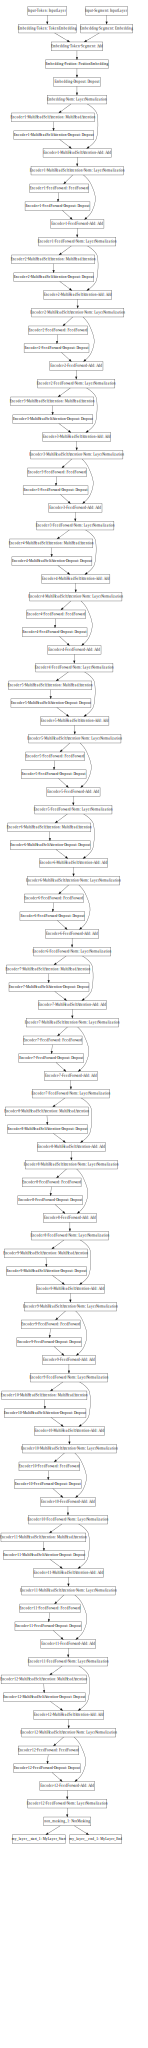

In [0]:
from IPython.display import SVG
from keras.utils import model_to_dot


SVG(model_to_dot(get_bert_finetuning_model(model), dpi=65).create(prog='dot', format='svg'))


훈련을 시작합니다.  
1epoch을 훈련해 보고, 결과를 확인하고 훈련을 다시 시작할 예정입니다.

In [0]:
sess = K.get_session()
uninitialized_variables = set([i.decode('ascii') for i in sess.run(tf.report_uninitialized_variables())])
init = tf.variables_initializer([v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables])
sess.run(init)

bert_model = get_bert_finetuning_model(model)
bert_model.summary()
history = bert_model.fit(train_x, train_y, batch_size=10, validation_split=0.05, shuffle=False, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
well
(?, 384, 768)
(?, 384, 2)
(2, ?, 384)
(?, 384) (?, 384)
No error
(?, 384, 768)
(2, ?, 384)
(?, 384) (?, 384)
No error
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 384)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 384)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 384, 768), ( 91812096    Input-Token[0][0]                
_________________________________________________________________________

g드라이브상에 squad 모델을 저장할 경로 지정

In [0]:
path = "gdrive/My Drive/Colab Notebooks/squad"

BERT MODEL을 저장합니다.

In [0]:
bert_model.save_weights(path+"/squad_wordpiece.h5")

버트 모형을 다시 훈련합니다.  
이번에는 validation_split을 입력하지 않아서 전체 데이터가 훈련 되도록 만들어 줍니다.

In [0]:
bert_model.compile(optimizer=RAdam(learning_rate=0.00003, decay=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
bert_model.fit(train_x, train_y, batch_size=10, shuffle=False, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1
87284/87284 [==============================] - 9501s 109ms/step - loss: 1.0188 - my_layer__start_1_loss: 0.5568 - my_layer__end_1_loss: 0.4620 - my_layer__start_1_acc: 0.8083 - my_layer__end_1_acc: 0.8504


In [0]:
bert_model.save_weights(path+"/squad_wordpiece_2.h5")

버트 모형을 한번 더 훈련시켜 줍니다. learning_rate을 0.00001로 바꿔 줍니다.

In [0]:
bert_model.compile(optimizer=RAdam(learning_rate=0.00001, decay=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
bert_model.save_weights(path+"/squad_wordpiece_3.h5")

재사용을 위해 bert_model을 지드라이브에 저장해줍니다.

버트 모형을 로드해줍니다. 이미 로드하였던 모델에 계수들만 살짝 얹혀 줍니다.

In [0]:
bert_model = get_bert_finetuning_model(model)
bert_model.load_weights(path+"/squad_wordpiece_3.h5")

Test data set에 대한 bert_input을 만들어 줍니다.  
Train data set과는 다르게 label을 생성하지 않습니다.

In [0]:
def convert_pred_data(question, doc):
    global tokenizer
    indices, segments = [], []
    ids, segment = tokenizer.encode(question, doc, max_len=SEQ_LEN)
    indices.append(ids)
    segments.append(segment)
    indices_x = np.array(indices)
    segments = np.array(segments)
    return [indices_x, segments]

def load_pred_data(question, doc):
    data_x = convert_pred_data(question, doc)
    return data_x

질문과 문장을 받아 답을 알려주는 함수를 정의합니다.

In [0]:
def predict_letter(question, doc):
  
  test_input = load_pred_data(question, doc)
  test_start, test_end = bert_model.predict(test_input)
  
  indexes = tokenizer.encode(question, doc, max_len=SEQ_LEN)[0]
  start = np.argmax(test_start, axis=1).item()
  end = np.argmax(test_end, axis=1).item()
  start_tok = indexes[start]
  end_tok = indexes[end]
  print("Question : ", question)
  
  print("-"*50)
  print("Context : ", end = " ")
  
  def split_text(text, n):
    for line in text.splitlines():
        while len(line) > n:
           x, line = line[:n], line[n:]
           yield x
        yield line

  

  for line in split_text(doc, 150):
    print(line)

  print("-"*50)
  print("ANSWER : ", end = " ")
  print("\n")
  sentences = []
  
  for i in range(start, end+1):
    token_based_word = reverse_token_dict[indexes[i]]
    sentences.append(token_based_word)
    print(token_based_word, end= " ")
  
  print("\n")
  print("Untokenized Answer : ", end = "")
  for w in sentences:
    if w.startswith("##"):
      w = w.replace("##", "")
    else:
      w = " " + w
    
    print(w, end="")
  print("")

SQAUD 데이터 셋에서 test 용도로 쓰이는 dev 파일을 PANDAS DATAFRAME 형식으로 불러오는 함수를 정의합니다.  
train 데이터와 모양이 약간 다르기 때문에, 함수를 새로 정의해야 합니다.

In [0]:
def squad_json_to_dataframe_dev(input_file_path, record_path = ['data','paragraphs','qas','answers'],
                           verbose = 1):
    """
    input_file_path: path to the squad json file.
    record_path: path to deepest level in json file default value is
    ['data','paragraphs','qas','answers']
    verbose: 0 to suppress it default is 1
    """
    if verbose:
        print("Reading the json file")    
    file = json.loads(open(input_file_path).read())
    if verbose:
        print("processing...")
    # parsing different level's in the json file
    js = pd.io.json.json_normalize(file , record_path )
    m = pd.io.json.json_normalize(file, record_path[:-1] )
    r = pd.io.json.json_normalize(file,record_path[:-2])
    
    #combining it into single dataframe
    idx = np.repeat(r['context'].values, r.qas.str.len())
    m['context'] = idx
    main = m[['id','question','context','answers']].set_index('id').reset_index()
    main['c_id'] = main['context'].factorize()[0]
    if verbose:
        print("shape of the dataframe is {}".format(main.shape))
        print("Done")
    return main

In [0]:
input_file_path ='dev-v1.1.json'
record_path = ['data','paragraphs','qas','answers']
verbose = 0
dev = squad_json_to_dataframe_dev(input_file_path=input_file_path,record_path=record_path)

Reading the json file
processing...
shape of the dataframe is (10570, 5)
Done


TEST DATA가 잘 불려왔는지 확인해 보겠습니다.

In [0]:
dev

,id,question,context,answers,c_id
0,56be4db0acb8001400a502ec,Which NFL team represented the AFC at Super Bo...,Super Bowl 50 was an American football game to...,"[{'answer_start': 177, 'text': 'Denver Broncos...",0
1,56be4db0acb8001400a502ed,Which NFL team represented the NFC at Super Bo...,Super Bowl 50 was an American football game to...,"[{'answer_start': 249, 'text': 'Carolina Panth...",0
2,56be4db0acb8001400a502ee,Where did Super Bowl 50 take place?,Super Bowl 50 was an American football game to...,"[{'answer_start': 403, 'text': 'Santa Clara, C...",0
3,56be4db0acb8001400a502ef,Which NFL team won Super Bowl 50?,Super Bowl 50 was an American football game to...,"[{'answer_start': 177, 'text': 'Denver Broncos...",0
4,56be4db0acb8001400a502f0,What color was used to emphasize the 50th anni...,Super Bowl 50 was an American football game to...,"[{'answer_start': 488, 'text': 'gold'}, {'answ...",0
...,...,...,...,...,...
10565,5737aafd1c456719005744fb,What is the metric term less used than the New...,"The pound-force has a metric counterpart, less...","[{'answer_start': 82, 'text': 'kilogram-force'...",2066
10566,5737aafd1c456719005744fc,What is the kilogram-force sometimes reffered ...,"The pound-force has a metric counterpart, less...","[{'answer_start': 114, 'text': 'kilopond'}, {'...",2066
10567,5737aafd1c456719005744fd,What is a very seldom used unit of mass in the...,"The pound-force has a metric counterpart, less...","[{'answer_start': 274, 'text': 'slug'}, {'answ...",2066
10568,5737aafd1c456719005744fe,What seldom used term of a unit of force equal...,"The pound-force has a metric counterpart, less...","[{'answer_start': 712, 'text': 'kip'}, {'answe...",2066


테스트 데이터에 대해서 결과를 확인합니다.  
훈련에 사용하지 않은 테스트 데이터에 대한 예측을 제법 잘 수행하는 것을 보실 수 있겠습니다.

In [0]:
import random
for i in random.sample(range(100),100):
  doc = dev['context'][i]
  question = dev['question'][i]
  answers = dev['answers'][i]
  predict_letter(question, doc)
  print("")
  print("real answer : ", answers)
  print("")

Question :  How many tackles did Von Miller accomlish by himself in the game?
--------------------------------------------------
Context :  The Broncos took an early lead in Super Bowl 50 and never trailed. Newton was limited by Denver's defense, which sacked him seven times and forced him
 into three turnovers, including a fumble which they recovered for a touchdown. Denver linebacker Von Miller was named Super Bowl MVP, recording five 
solo tackles, 2½ sacks, and two forced fumbles.
--------------------------------------------------
ANSWER :  

five 

Untokenized Answer :  five

real answer :  [{'answer_start': 295, 'text': 'five'}, {'answer_start': 295, 'text': 'five'}, {'answer_start': 295, 'text': 'five'}]

Question :  What year did the Carolina Panthers form?
--------------------------------------------------
Context :  The Panthers finished the regular season with a 15–1 record, and quarterback Cam Newton was named the NFL Most Valuable Player (MVP). They defeated th
e Arizona C